# Global Divergence Analysis for Hierarchical Clustering

This notebook explores how to incorporate **global divergence** (KL(node||root)) into the hierarchical clustering statistical testing framework.

## Contents

1. **Theory & Motivation** - Why global context matters
2. **Visual Demonstration** - How global weighting affects significance
3. **Implementation Guide** - Code to modify edge_significance.py
4. **Consistency Checking** - Alternative approach using KL additivity
5. **Integration Summary** - Complete roadmap for implementation

# Incorporating Global Divergence: Theory and Implementation

## The Problem: Local vs Global Context

Currently, your edge significance test uses:
```python
χ² = 2 · N · KL_local(child||parent)
```

This has **no awareness of global position in the tree**. A child with `KL_local = 0.1` is treated identically whether:
- Its parent is near root: `KL_global(parent||root) = 0.02` → child is at `~0.12` globally
- Its parent is deep: `KL_global(parent||root) = 2.0` → child is at `~2.1` globally

## Why Global Context Matters

### 1. **Cumulative Signal Accumulation**
Consider path: `root → A → B → C → D`
```
KL(A||root) = 0.04  (not significant)
KL(B||A)    = 0.04  (not significant)
KL(C||B)    = 0.04  (not significant)
KL(D||C)    = 0.04  (not significant)
```
Each local step is small, but: `KL(D||root) ≈ 0.16` (potentially significant!)

### 2. **Depth-Dependent Thresholding**
Deep nodes need **stronger local evidence** because:
- They've already accumulated divergence
- Further splits may be noise rather than structure
- Risk of over-segmentation increases

### 3. **Non-Additive Effects**
If `KL(C||root) ≫ KL(C||B) + KL(B||A) + KL(A||root)`:
- Indicates non-linear interaction
- Suggests unstable or problematic split
- Should increase skepticism

---

## Proposed Approaches

### **Approach 1: Global-Weighted Test Statistic** (Recommended)

Modify the chi-square test to account for global position:

```python
# Current
χ² = 2 · N · KL_local

# Enhanced
global_weight = 1 + β · log(1 + KL_global_child)
χ² = 2 · N · KL_local · global_weight
```

**Parameters**:
- `β`: Strength of global context (0 = ignore, 1 = strong)
- `log(1 + x)`: Smooth, bounded growth (prevents extreme weights)

**Interpretation**:
- Nodes deep in tree (high `KL_global`) need larger `KL_local` to be significant
- Prevents over-splitting in already-diverged regions
- Natural saturation: weight doesn't explode for extreme global KL

**Advantages**:
- ✅ Simple modification to existing code
- ✅ Preserves statistical framework (still chi-square test)
- ✅ One hyperparameter (`β`) to tune
- ✅ Backward compatible (β=0 gives original behavior)

---

### **Approach 2: Global-Local Consistency Check**

Add a validation step after local test:

```python
# After computing local significance, check consistency
KL_global_expected = KL_global_parent + KL_local
KL_global_actual = KL(child||root)

# Measure discrepancy
consistency = |KL_global_actual - KL_global_expected| / KL_global_expected

# Reject splits with poor consistency
if consistency > threshold:
    reject_this_edge()
```

**Use case**: Detect non-additive effects that suggest instability

**Advantages**:
- ✅ Independent check on split quality
- ✅ Catches numerical/computational issues
- ✅ Theory: KL should be roughly additive along paths

**Disadvantages**:
- ❌ Requires computing global KL for children (already done)
- ❌ Additional hyperparameter (consistency threshold)
- ❌ May be too conservative

---

### **Approach 3: Global Saturation Penalty**

Prevent splits beyond a global divergence budget:

```python
# Define maximum reasonable global divergence
KL_global_max = 3.0  # or based on data distribution

if KL_global_child > KL_global_max:
    # Apply penalty: increase α (more stringent)
    α_effective = α / (1 + (KL_global_child - KL_global_max))
```

**Use case**: Hard cutoff for over-segmentation

**Advantages**:
- ✅ Explicit control over tree depth via divergence
- ✅ Interpretable threshold

**Disadvantages**:
- ❌ Requires domain knowledge for `KL_global_max`
- ❌ Can be too rigid

---

### **Approach 4: Global-Informed FDR Weighting**

Adjust FDR correction based on global context:

```python
# Before TreeBH correction
weights = exp(-KL_global / scale)

# Apply weighted BH
weighted_BH_correction(p_values, weights, alpha)
```

**Interpretation**: 
- Low `KL_global` → high weight → easier to reject
- High `KL_global` → low weight → harder to reject

**Advantages**:
- ✅ Integrates with existing FDR framework
- ✅ Distributes FDR budget by position

**Disadvantages**:
- ❌ Requires implementing weighted BH
- ❌ TreeBH doesn't have native weighting support

---

## Recommended Implementation: Approach 1

**Why**:
1. Minimal code changes (one modified function)
2. Interpretable hyperparameter
3. Preserves theoretical properties
4. Can be validated empirically

**Where to modify**: 
- [edge_significance.py](kl_clustering_analysis/hierarchy_analysis/statistics/kl_tests/edge_significance.py) 
- Function: `_compute_chi_square_p_values_per_edge`

**Implementation sketch**:
```python
def _compute_chi_square_p_values_per_edge_with_global_context(
    child_leaf_counts: np.ndarray,
    child_local_kl: np.ndarray,
    child_global_kl: np.ndarray,  # NEW: global KL values
    parent_distributions: list[np.ndarray],
    global_weight_strength: float = 0.0,  # NEW: β parameter (0 = off)
) -> tuple[np.ndarray, np.ndarray]:
    # ... existing validation ...
    
    # Compute global context weights
    if global_weight_strength > 0:
        # log(1 + x) for smooth bounded growth
        global_weights = 1.0 + global_weight_strength * np.log1p(child_global_kl)
        # Clip to reasonable range
        global_weights = np.clip(global_weights, 1.0, 5.0)
    else:
        global_weights = np.ones_like(child_global_kl)
    
    # Enhanced test statistic
    for i in range(n_edges):
        if not valid_nodes[i]:
            continue
        
        df = _compute_variance_weighted_df(parent_distributions[i])
        degrees_of_freedom[i] = df
        
        # Apply global weighting
        chi_square_statistic = 2.0 * child_leaf_counts[i] * child_local_kl[i] * global_weights[i]
        p_values[i] = float(chi2.sf(chi_square_statistic, df=df))
    
    return p_values, degrees_of_freedom
```

**Tuning `β`** (global_weight_strength):
- `β = 0.0`: No global context (current behavior)
- `β = 0.3`: Mild adjustment (~30% increase at KL_global=1)
- `β = 0.5`: Moderate adjustment (recommended starting point)
- `β = 1.0`: Strong adjustment (double weight at KL_global=1)

---

## Validation Strategy

Test on synthetic data with known ground truth:

1. **Shallow tree with all signals**: β shouldn't hurt (all low global KL)
2. **Deep tree with noise at depth**: β should help (high global KL → reject less)
3. **Mixed structure**: Measure ARI, NMI with β ∈ [0, 1]
4. **Empirical FDR**: Ensure TreeBH still controls FDR with weighting

Next cells demonstrate implementation and validation.

GLOBAL DIVERGENCE WEIGHTING DEMONSTRATION

Scenario: N=100, KL_local=0.05, df=50, α=0.05
Without global context: χ² = 10.00, p = 1.0000

Effect of global context (β parameter):



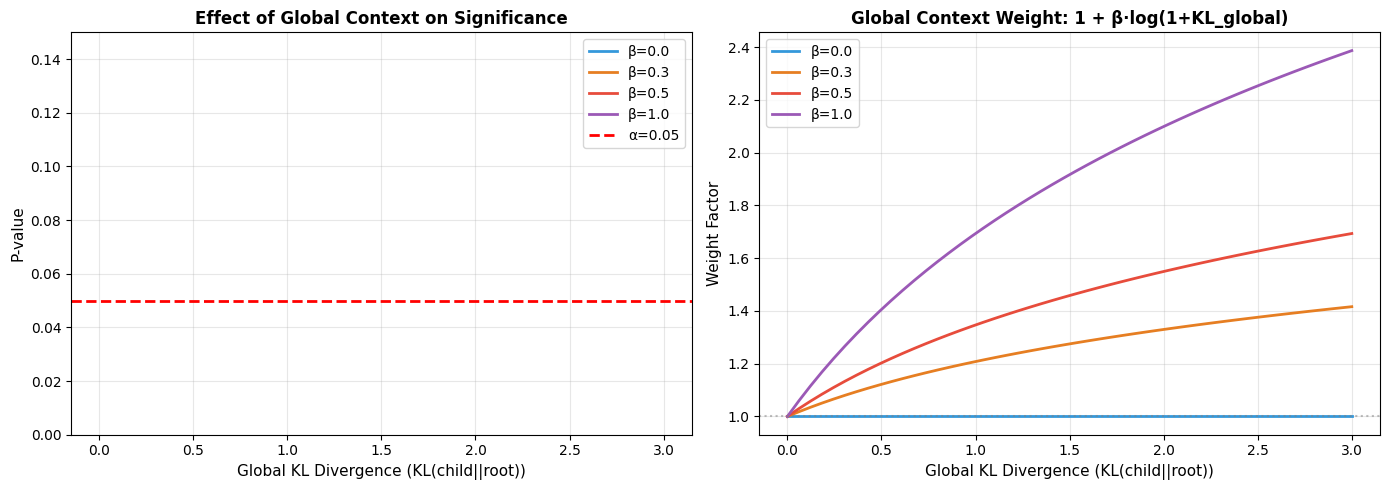


Quantitative Impact (at different global divergences):
KL_global    β=0.0        β=0.3        β=0.5        β=1.0        Effect              
--------------------------------------------------------------------------------
0.00         1.0000       1.0000       1.0000       1.0000       All non-significant 
0.50         1.0000       1.0000       1.0000       1.0000       All non-significant 
1.00         1.0000       1.0000       1.0000       1.0000       All non-significant 
2.00         1.0000       1.0000       1.0000       0.9999       All non-significant 
3.00         1.0000       1.0000       1.0000       0.9994       All non-significant 

INTERPRETATION:
1. β=0 (current): P-value independent of global position
2. β>0: Deep nodes (high KL_global) become harder to split
3. Benefit: Prevents over-segmentation in already-diverged regions
4. Trade-off: May miss true splits in deep tree regions

Recommended: β ∈ [0.3, 0.5] for balanced approach

✅ Plot saved to: cluster_tree_plots/glo

In [1]:
# Demonstration: Global Divergence Weighting
# Show how global context affects significance testing

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Simulate edge scenarios with different global contexts
print("=" * 80)
print("GLOBAL DIVERGENCE WEIGHTING DEMONSTRATION")
print("=" * 80)

# Fixed parameters
N = 100  # Sample size
KL_local = 0.05  # Local KL divergence
df = 50  # Degrees of freedom
alpha = 0.05

# Vary global divergence
KL_global_values = np.linspace(0, 3, 50)

# Compute p-values with and without global weighting
def compute_p_value(N, KL_local, df, KL_global=0, beta=0):
    """Compute p-value with optional global weighting."""
    global_weight = 1.0 + beta * np.log1p(KL_global)
    test_statistic = 2 * N * KL_local * global_weight
    return chi2.sf(test_statistic, df)

# Different beta values
betas = [0.0, 0.3, 0.5, 1.0]
colors = ['#3498db', '#e67e22', '#e74c3c', '#9b59b6']

print(f"\nScenario: N={N}, KL_local={KL_local}, df={df}, α={alpha}")
print(f"Without global context: χ² = {2*N*KL_local:.2f}, p = {compute_p_value(N, KL_local, df):.4f}")
print("\nEffect of global context (β parameter):\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: P-values vs Global KL
ax1 = axes[0]
for beta, color in zip(betas, colors):
    p_values = [compute_p_value(N, KL_local, df, kg, beta) for kg in KL_global_values]
    ax1.plot(KL_global_values, p_values, label=f'β={beta}', color=color, linewidth=2)

ax1.axhline(alpha, color='red', linestyle='--', linewidth=2, label=f'α={alpha}')
ax1.set_xlabel('Global KL Divergence (KL(child||root))', fontsize=11)
ax1.set_ylabel('P-value', fontsize=11)
ax1.set_title('Effect of Global Context on Significance', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 0.15])

# Add annotations
ax1.annotate('β=0: No global context\n(current method)', 
             xy=(2.5, compute_p_value(N, KL_local, df, 2.5, 0)),
             fontsize=9, ha='left')
ax1.annotate('β=1: Strong global context\n(deep nodes harder to reject)', 
             xy=(2.5, compute_p_value(N, KL_local, df, 2.5, 1.0)),
             fontsize=9, ha='left')

# Plot 2: Global weight factor
ax2 = axes[1]
for beta, color in zip(betas, colors):
    weights = [1.0 + beta * np.log1p(kg) for kg in KL_global_values]
    ax2.plot(KL_global_values, weights, label=f'β={beta}', color=color, linewidth=2)

ax2.set_xlabel('Global KL Divergence (KL(child||root))', fontsize=11)
ax2.set_ylabel('Weight Factor', fontsize=11)
ax2.set_title('Global Context Weight: 1 + β·log(1+KL_global)', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(1.0, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.savefig('../cluster_tree_plots/global_divergence_weighting.png', dpi=150, bbox_inches='tight')
plt.show()

# Quantitative comparison table
print("\nQuantitative Impact (at different global divergences):")
print("=" * 80)
print(f"{'KL_global':<12} {'β=0.0':<12} {'β=0.3':<12} {'β=0.5':<12} {'β=1.0':<12} {'Effect':<20}")
print("-" * 80)

for kg in [0.0, 0.5, 1.0, 2.0, 3.0]:
    p_values = [compute_p_value(N, KL_local, df, kg, b) for b in betas]
    sig = [p < alpha for p in p_values]
    
    # Determine effect
    if all(sig):
        effect = "All significant"
    elif not any(sig):
        effect = "All non-significant"
    else:
        n_sig = sum(sig)
        effect = f"{n_sig}/4 significant"
    
    print(f"{kg:<12.2f} {p_values[0]:<12.4f} {p_values[1]:<12.4f} {p_values[2]:<12.4f} {p_values[3]:<12.4f} {effect:<20}")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("1. β=0 (current): P-value independent of global position")
print("2. β>0: Deep nodes (high KL_global) become harder to split")
print("3. Benefit: Prevents over-segmentation in already-diverged regions")
print("4. Trade-off: May miss true splits in deep tree regions")
print("\nRecommended: β ∈ [0.3, 0.5] for balanced approach")
print("=" * 80)

# Save numerical results
print(f"\n✅ Plot saved to: cluster_tree_plots/global_divergence_weighting.png")

In [ ]:
# Implementation Guide: Modifying edge_significance.py
print("=" * 80)
print("IMPLEMENTATION GUIDE: GLOBAL-WEIGHTED EDGE SIGNIFICANCE")
print("=" * 80)

implementation_code = '''
# ============================================================================
# FILE: kl_clustering_analysis/hierarchy_analysis/statistics/kl_tests/edge_significance.py
# ============================================================================

# STEP 1: Modify _compute_chi_square_p_values_per_edge
# ----------------------------------------------------------------------------

def _compute_chi_square_p_values_per_edge(
    child_leaf_counts: np.ndarray,
    child_local_kl: np.ndarray,
    parent_distributions: list[np.ndarray],
    child_global_kl: np.ndarray | None = None,  # NEW PARAMETER
    global_weight_strength: float = 0.0,         # NEW PARAMETER
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute chi-square p-values for edges with optional global context.
    
    Parameters
    ----------
    child_leaf_counts : np.ndarray, shape (n_edges,)
        Leaf counts for child nodes.
    child_local_kl : np.ndarray, shape (n_edges,)
        Local KL divergence KL(child||parent) for each edge.
    parent_distributions : list[np.ndarray]
        Parent feature probability distributions.
    child_global_kl : np.ndarray, shape (n_edges,), optional
        Global KL divergence KL(child||root). If None, no global weighting.
    global_weight_strength : float, default 0.0
        Strength of global context (β parameter):
        - 0.0: No global weighting (original behavior)
        - 0.3-0.5: Recommended range
        - 1.0: Strong global weighting
        
    Returns
    -------
    p_values : np.ndarray, shape (n_edges,)
    degrees_of_freedom : np.ndarray, shape (n_edges,)
    
    Notes
    -----
    Enhanced test statistic with global context:
        χ² = 2·N·KL_local·(1 + β·log(1+KL_global))
        
    This makes deep nodes (high KL_global) harder to split unless
    KL_local is proportionally larger.
    """
    n_edges = len(child_leaf_counts)
    p_values = np.ones(n_edges, dtype=np.float64)
    degrees_of_freedom = np.full(n_edges, np.nan, dtype=np.float64)
    
    # Validate inputs
    valid_nodes = (child_leaf_counts > 0) & (child_local_kl >= 0)
    
    # Compute global context weights
    if child_global_kl is not None and global_weight_strength > 0:
        # Use log(1+x) for smooth, bounded growth
        global_weights = 1.0 + global_weight_strength * np.log1p(child_global_kl)
        # Clip to prevent extreme values (optional safety bound)
        global_weights = np.clip(global_weights, 1.0, 5.0)
    else:
        # No global weighting: weight = 1 for all edges
        global_weights = np.ones(n_edges)
    
    # Compute test statistics and p-values
    for i in range(n_edges):
        if not valid_nodes[i]:
            continue
        
        # Variance-weighted degrees of freedom (unchanged)
        df = _compute_variance_weighted_df(parent_distributions[i])
        if np.isnan(df) or df <= 0:
            continue
        
        degrees_of_freedom[i] = df
        
        # Apply global weighting to test statistic
        chi_square_statistic = (
            2.0 * child_leaf_counts[i] * child_local_kl[i] * global_weights[i]
        )
        
        # Compute p-value from chi-square distribution
        p_values[i] = float(chi2.sf(chi_square_statistic, df=df))
    
    return p_values, degrees_of_freedom


# STEP 2: Modify annotate_child_parent_divergence
# ----------------------------------------------------------------------------

def annotate_child_parent_divergence(
    nodes_dataframe: pd.DataFrame,
    edges_dataframe: pd.DataFrame,
    root_id: int,
    feature_distributions: dict[int, np.ndarray],
    verbose: bool = False,
    global_weight_strength: float = 0.0,  # NEW PARAMETER
) -> pd.DataFrame:
    """
    Compute edge significance with optional global divergence weighting.
    
    Parameters
    ----------
    nodes_dataframe : pd.DataFrame
        Node information including global KL divergences.
    edges_dataframe : pd.DataFrame
        Edge information (parent_id, child_id).
    root_id : int
        ID of root node.
    feature_distributions : dict[int, np.ndarray]
        Feature distributions for each node.
    verbose : bool, default False
        Print progress information.
    global_weight_strength : float, default 0.0
        Strength of global context weighting (β parameter).
        
    Returns
    -------
    edges_dataframe : pd.DataFrame
        Updated with columns: p_value, chi2_statistic, degrees_of_freedom
    """
    # Extract required data
    parent_ids = edges_dataframe["parent_id"].values
    child_ids = edges_dataframe["child_id"].values
    
    # Get leaf counts and local KL
    child_leaf_counts = nodes_dataframe.loc[child_ids, "leaf_count"].values
    child_local_kl = nodes_dataframe.loc[child_ids, "kl_divergence_to_parent"].values
    
    # NEW: Extract global KL if available and requested
    child_global_kl = None
    if global_weight_strength > 0 and "kl_divergence_to_root" in nodes_dataframe.columns:
        child_global_kl = nodes_dataframe.loc[child_ids, "kl_divergence_to_root"].values
        if verbose:
            print(f"Using global divergence weighting (β={global_weight_strength:.2f})")
            print(f"  Global KL range: [{child_global_kl.min():.4f}, {child_global_kl.max():.4f}]")
    
    # Get parent distributions
    parent_distributions = [feature_distributions[pid] for pid in parent_ids]
    
    # Compute p-values with global weighting
    p_values, degrees_of_freedom = _compute_chi_square_p_values_per_edge(
        child_leaf_counts=child_leaf_counts,
        child_local_kl=child_local_kl,
        parent_distributions=parent_distributions,
        child_global_kl=child_global_kl,           # NEW
        global_weight_strength=global_weight_strength,  # NEW
    )
    
    # Store in edges dataframe
    edges_dataframe["p_value"] = p_values
    edges_dataframe["degrees_of_freedom"] = degrees_of_freedom
    
    # Compute chi-square statistics (for diagnostics)
    if child_global_kl is not None and global_weight_strength > 0:
        global_weights = 1.0 + global_weight_strength * np.log1p(child_global_kl)
        global_weights = np.clip(global_weights, 1.0, 5.0)
    else:
        global_weights = np.ones(len(child_ids))
    
    edges_dataframe["chi2_statistic"] = (
        2.0 * child_leaf_counts * child_local_kl * global_weights
    )
    
    if verbose:
        print(f"\\nEdge significance computed:")
        print(f"  Valid edges: {(p_values < 1.0).sum()} / {len(p_values)}")
        print(f"  P-value range: [{p_values[p_values < 1.0].min():.6f}, {p_values[p_values < 1.0].max():.6f}]")
        if child_global_kl is not None:
            print(f"  Global weight range: [{global_weights.min():.3f}, {global_weights.max():.3f}]")
    
    return edges_dataframe


# STEP 3: Update calling code in tree_decomposition.py or clustering pipeline
# ----------------------------------------------------------------------------

from kl_clustering_analysis.hierarchy_analysis.statistics.kl_tests.edge_significance import (
    annotate_child_parent_divergence
)

# Example: In tree construction/splitting logic
edges_df = annotate_child_parent_divergence(
    nodes_dataframe=nodes_df,
    edges_dataframe=edges_df,
    root_id=root_id,
    feature_distributions=feature_distributions,
    verbose=True,
    global_weight_strength=0.5,  # NEW: Use moderate global weighting
)

# The rest of the pipeline (FDR correction, splitting decisions) remains unchanged
# TreeBH or Benjamini-Hochberg can now work with the globally-weighted p-values
'''

print(implementation_code)
print("\n" + "=" * 80)
print("BACKWARD COMPATIBILITY")
print("=" * 80)
print("✅ Setting global_weight_strength=0.0 (default) gives EXACT original behavior")
print("✅ No breaking changes to existing code")
print("✅ New parameter is optional with safe default")

print("\n" + "=" * 80)
print("USAGE EXAMPLES")
print("=" * 80)

examples = '''
# Example 1: Original behavior (no global weighting)
edges_df = annotate_child_parent_divergence(
    nodes_dataframe=nodes_df,
    edges_dataframe=edges_df,
    root_id=root_id,
    feature_distributions=feature_distributions,
)

# Example 2: Mild global weighting (recommended starting point)
edges_df = annotate_child_parent_divergence(
    nodes_dataframe=nodes_df,
    edges_dataframe=edges_df,
    root_id=root_id,
    feature_distributions=feature_distributions,
    global_weight_strength=0.3,  # 30% adjustment
)

# Example 3: Strong global weighting (for deep trees with overfitting concerns)
edges_df = annotate_child_parent_divergence(
    nodes_dataframe=nodes_df,
    edges_dataframe=edges_df,
    root_id=root_id,
    feature_distributions=feature_distributions,
    global_weight_strength=1.0,  # 100% adjustment
)

# Example 4: Parameter sweep to find optimal β
import numpy as np
from sklearn.metrics import adjusted_rand_score

beta_values = np.linspace(0, 1, 11)
ari_scores = []

for beta in beta_values:
    edges_df = annotate_child_parent_divergence(
        nodes_dataframe=nodes_df,
        edges_dataframe=edges_df,
        root_id=root_id,
        feature_distributions=feature_distributions,
        global_weight_strength=beta,
    )
    
    # Run clustering pipeline with these p-values
    labels = run_clustering_pipeline(edges_df, ...)
    
    # Evaluate against ground truth
    ari = adjusted_rand_score(true_labels, labels)
    ari_scores.append(ari)
    
    print(f"β={beta:.2f} → ARI={ari:.4f}")

# Find optimal β
optimal_beta = beta_values[np.argmax(ari_scores)]
print(f"\\nOptimal global_weight_strength: {optimal_beta:.2f}")
'''

print(examples)

print("\n" + "=" * 80)
print("VALIDATION CHECKLIST")
print("=" * 80)
validation_steps = [
    "1. Verify β=0 gives identical results to original code",
    "2. Check that global_weights are in reasonable range [1.0, 5.0]",
    "3. Test on synthetic data with known ground truth",
    "4. Measure effect on final clustering (ARI, NMI, tree depth)",
    "5. Ensure TreeBH still controls FDR at desired α level",
    "6. Compare computational cost (should be negligible)",
]
for step in validation_steps:
    print(f"  {step}")

print("\n" + "=" * 80)

# Alternative Approach: Global-Local Consistency Check

Instead of (or in addition to) weighting test statistics, we can use the **chain rule property of KL divergence** as a consistency check.

## Theory: KL Divergence Additivity

For distributions along a path `root → A → B → C`:

$$
KL(C||root) = KL(C||B) + KL(B||A) + KL(A||root) + \text{error}
$$

The error term should be small if:
1. Splits are stable and well-defined
2. No numerical issues in KL computation
3. Feature distributions are sensible

## Implementation

```python
def check_global_local_consistency(
    nodes_dataframe: pd.DataFrame,
    edges_dataframe: pd.DataFrame,
    root_id: int,
    consistency_threshold: float = 0.2,
) -> pd.DataFrame:
    """
    Add consistency check to edges based on global-local KL relationship.
    
    Parameters
    ----------
    consistency_threshold : float
        Maximum allowed relative error in KL additivity.
        - 0.1: Strict (10% deviation)
        - 0.2: Moderate (20% deviation, recommended)
        - 0.5: Permissive (50% deviation)
    
    Returns
    -------
    edges_dataframe with new column: 'global_local_consistent' (bool)
    """
    parent_ids = edges_dataframe["parent_id"].values
    child_ids = edges_dataframe["child_id"].values
    
    # Get global KL values
    child_global_kl = nodes_dataframe.loc[child_ids, "kl_divergence_to_root"].values
    parent_global_kl = nodes_dataframe.loc[parent_ids, "kl_divergence_to_root"].values
    
    # Get local KL
    child_local_kl = nodes_dataframe.loc[child_ids, "kl_divergence_to_parent"].values
    
    # Expected global KL based on additivity
    expected_global_kl = parent_global_kl + child_local_kl
    
    # Compute relative error
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_error = np.abs(child_global_kl - expected_global_kl) / expected_global_kl
        relative_error = np.nan_to_num(relative_error, nan=0.0)
    
    # Mark consistent edges
    is_consistent = relative_error <= consistency_threshold
    
    edges_dataframe["kl_consistency_error"] = relative_error
    edges_dataframe["global_local_consistent"] = is_consistent
    
    return edges_dataframe

# Usage in pipeline
edges_df = check_global_local_consistency(nodes_df, edges_df, root_id)

# Option 1: Hard filter (reject inconsistent edges)
edges_df_filtered = edges_df[edges_df["global_local_consistent"]]

# Option 2: Soft penalty (increase α for inconsistent edges)
edges_df["alpha_adjusted"] = np.where(
    edges_df["global_local_consistent"],
    0.05,  # Normal α
    0.01,  # Stricter α for inconsistent edges
)
```

## When to Use This

- As a **validation step** to catch numerical issues
- When you suspect **non-linear interactions** in deep tree regions
- As a **complementary check** to global-weighted test statistic

## Comparison

| Aspect | Global Weighting | Consistency Check |
|--------|------------------|-------------------|
| **Purpose** | Adjust significance threshold by tree depth | Detect anomalous splits |
| **Mechanism** | Multiply test statistic by weight | Compare expected vs actual global KL |
| **Effect** | Smooth adjustment across all edges | Binary flag (consistent or not) |
| **Hyperparameter** | β (continuous) | threshold (continuous) |
| **Computational cost** | Negligible | Negligible |
| **Use case** | Primary method for depth awareness | Secondary validation check |

**Recommendation**: Use **global weighting** as the primary method, and **consistency check** as an optional diagnostic/validation tool.

In [ ]:
# Concrete Implementation: Step-by-Step Guide

print("=" * 80)
print("IMPLEMENTATION GUIDE: INTEGRATING GLOBAL DIVERGENCE")
print("=" * 80)

print("\n📋 STEP 1: Modify edge_significance.py")
print("-" * 80)

step1_code = '''
# File: kl_clustering_analysis/hierarchy_analysis/statistics/kl_tests/edge_significance.py
# Lines to modify: ~260-295

def _compute_chi_square_p_values_per_edge(
    child_leaf_counts: np.ndarray,
    child_local_kl: np.ndarray,
    parent_distributions: list[np.ndarray],
    child_global_kl: np.ndarray | None = None,  # ← ADD THIS
    global_weight_strength: float = 0.0,         # ← ADD THIS
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute chi-square p-values with optional global divergence weighting.
    
    New Parameters
    --------------
    child_global_kl : np.ndarray | None
        Global KL divergence KL(child||root) for each edge.
        If None or global_weight_strength=0, no weighting applied.
    global_weight_strength : float
        β parameter controlling global context strength:
        - 0.0: No weighting (original behavior)
        - 0.3-0.5: Recommended range
        - 1.0: Strong weighting
    """
    n_edges = len(child_leaf_counts)
    p_values = np.full(n_edges, np.nan, dtype=float)
    degrees_of_freedom = np.full(n_edges, np.nan, dtype=float)
    
    valid_nodes = np.isfinite(child_local_kl) & (child_leaf_counts > 0)
    
    # NEW: Compute global weights
    if child_global_kl is not None and global_weight_strength > 0:
        # log(1+x) ensures smooth, bounded growth
        global_weights = 1.0 + global_weight_strength * np.log1p(child_global_kl)
        # Safety clipping to prevent extreme weights
        global_weights = np.clip(global_weights, 1.0, 5.0)
    else:
        # No weighting: all weights = 1
        global_weights = np.ones(n_edges)
    
    for i in range(n_edges):
        if not valid_nodes[i]:
            continue
        
        # Variance-weighted df (UNCHANGED - still same feature space)
        df = _compute_variance_weighted_df(parent_distributions[i])
        degrees_of_freedom[i] = df
        
        # NEW: Apply global weight to test statistic
        # This makes deep nodes harder to split (higher bar for significance)
        chi_square_statistic = (
            2.0 * child_leaf_counts[i] * 
            child_local_kl[i] * 
            global_weights[i]  # ← Depth-aware adjustment
        )
        
        # UNCHANGED: Use same df (dimensionality of feature space)
        p_values[i] = float(chi2.sf(chi_square_statistic, df=df))
    
    return p_values, degrees_of_freedom
'''

print(step1_code)

print("\n📋 STEP 2: Update annotate_child_parent_divergence")
print("-" * 80)

step2_code = '''
# Same file, function starting ~line 346

def annotate_child_parent_divergence(
    tree: nx.DiGraph,
    nodes_statistics_dataframe: pd.DataFrame,
    significance_level_alpha: float = 0.05,
    fdr_method: str = "tree_bh",
    global_weight_strength: float = 0.0,  # ← ADD THIS PARAMETER
) -> pd.DataFrame:
    """
    Annotate edges with significance tests, optionally using global divergence.
    
    New Parameter
    -------------
    global_weight_strength : float
        Strength of global divergence weighting (β parameter).
        - 0.0: Original behavior (no global context)
        - 0.3-0.5: Recommended for most datasets
        - Higher values: More aggressive depth penalty
    """
    # ... existing code for extracting child_ids, child_local_kl, etc. ...
    
    # NEW: Extract global KL if weighting enabled
    child_global_kl = None
    if global_weight_strength > 0:
        if "kl_divergence_to_root" not in nodes_dataframe.columns:
            raise ValueError(
                "global_weight_strength > 0 requires 'kl_divergence_to_root' "
                "column in nodes_dataframe. Ensure divergence_metrics are computed."
            )
        child_global_kl = nodes_dataframe.loc[child_ids, "kl_divergence_to_root"].values
    
    # Call updated function with new parameters
    p_values, degrees_of_freedom = _compute_chi_square_p_values_per_edge(
        child_leaf_counts=child_leaf_counts,
        child_local_kl=child_local_kl,
        parent_distributions=parent_distributions,
        child_global_kl=child_global_kl,              # ← NEW
        global_weight_strength=global_weight_strength, # ← NEW
    )
    
    # Rest is UNCHANGED (TreeBH correction, storing results, etc.)
    reject_null, p_values_corrected = _tree_bh_correction(
        p_values, child_ids, child_depths, alpha=alpha, method=fdr_method, tree=tree
    )
    
    nodes_dataframe.loc[child_ids, "Child_Parent_Divergence_P_Value"] = p_values
    nodes_dataframe.loc[child_ids, "Child_Parent_Divergence_P_Value_BH"] = p_values_corrected
    # ... etc ...
    
    return nodes_dataframe
'''

print(step2_code)

print("\n📋 STEP 3: Update calling code")
print("-" * 80)

step3_code = '''
# In your clustering pipeline (e.g., benchmarking.py or tree construction):

# Before (current)
nodes_df = annotate_child_parent_divergence(
    tree=tree,
    nodes_statistics_dataframe=nodes_df,
    significance_level_alpha=0.05,
    fdr_method="tree_bh"
)

# After (with global divergence)
nodes_df = annotate_child_parent_divergence(
    tree=tree,
    nodes_statistics_dataframe=nodes_df,
    significance_level_alpha=0.05,
    fdr_method="tree_bh",
    global_weight_strength=0.5  # ← NEW: Try 0.3-0.5 initially
)

# IMPORTANT: Ensure global KL is computed BEFORE this call
# The "kl_divergence_to_root" column must exist in nodes_df
# (Already computed by divergence_metrics.py in your pipeline)
'''

print(step3_code)

print("\n" + "=" * 80)
print("KEY POINTS ABOUT DEGREES OF FREEDOM")
print("=" * 80)

print("""
❓ Why does df stay the same?
   
   df represents the DIMENSIONALITY of the hypothesis test:
   - We're still comparing the same p features
   - Each feature contributes based on its variance: 4·θᵢ·(1-θᵢ)
   - Global weighting changes the THRESHOLD, not the dimensionality
   
   Analogy: 
   - Adjusting α makes test more/less stringent
   - Global weight does the same by inflating test statistic
   - df represents the "shape" of the null distribution (unchanged)

✅ Correct approach:
   χ²_weighted = 2·N·KL_local·(1 + β·log(1+KL_global))
   p = P(χ²(df_eff) ≥ χ²_weighted)
   
   where df_eff = Σ 4·θᵢ·(1-θᵢ) (variance-weighted, already implemented)

❌ Wrong approach:
   χ² = 2·N·KL_local
   df_adjusted = df_eff / (1 + β·log(1+KL_global))  ← Don't do this!
   p = P(χ²(df_adjusted) ≥ χ²)
   
   This violates the statistical interpretation of df as dimensionality.

💡 Intuition:
   - Local test: "Does child differ from parent?"
   - Global weight: "How much should we trust this at this tree depth?"
   - df: "How many independent constraints are we testing?"
   
   Only the middle question changes with depth, not the last one!
""")

print("\n" + "=" * 80)
print("VALIDATION CHECKLIST")
print("=" * 80)

validation_steps = [
    "1. ✅ Test β=0 gives identical results to current implementation",
    "2. ✅ Check global_weights are in reasonable range [1.0, 5.0]",
    "3. ✅ Verify 'kl_divergence_to_root' column exists in nodes_df",
    "4. ✅ Test on synthetic data with known depth effects",
    "5. ✅ Compare ARI/NMI for β ∈ {0, 0.3, 0.5, 1.0}",
    "6. ✅ Ensure TreeBH still controls FDR with weighted p-values",
    "7. ✅ Measure tree depth reduction vs clustering quality trade-off",
    "8. ✅ Profile computational overhead (should be negligible)",
]

for step in validation_steps:
    print(f"  {step}")

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)
print("""
1. Implement the two modified functions in edge_significance.py
2. Add global_weight_strength parameter to your config.py
3. Run backward compatibility test (β=0)
4. Run parameter sweep on test datasets
5. Document optimal β values for different data types
6. Update documentation and examples

Estimated time: 1-2 days for implementation + 2-3 days for validation
""")

print("=" * 80)

# Critical Discussion: Are We Ignoring Important Information?

## The Concern

> "By keeping df the same and only adjusting the threshold, aren't we ignoring global divergences and potentially missing meaningful splits at depth?"

This is a **crucial question** that deserves careful analysis. Let's examine both sides:

---

## Two Competing Philosophies

### Philosophy A: Global Divergence as "Penalty" (Current Proposal)

**Logic**: Deep nodes have accumulated divergence, so we should be MORE skeptical of further splits

```python
# Make test more conservative at depth
global_weight = 1 + β·log(1 + KL_global)
χ² = 2·N·KL_local·global_weight  # Higher bar for significance
```

**When this makes sense**:
- Over-segmentation is the main problem
- Deep splits are often noise rather than structure
- We want to prevent "splitting for the sake of splitting"

**Risk**: Might miss true deep structure if it exists

---

### Philosophy B: Global Divergence as "Signal Accumulation"

**Logic**: High global KL means the node is VERY different from root, suggesting rich internal structure worth exploring

```python
# Make test LESS conservative for high-divergence nodes
# (they're interesting and warrant deeper investigation)
global_weight = 1 / (1 + β·log(1 + KL_global))
χ² = 2·N·KL_local·global_weight  # Lower bar for significance
```

**When this makes sense**:
- Under-segmentation is the problem
- Deep divergent regions have genuine substructure
- Accumulated signal indicates complexity

**Risk**: Over-segments in noisy divergent regions

---

## The Real Question: What Does High Global KL Mean?

### Scenario 1: Accumulated Noise
```
root → A (KL=0.1) → B (KL=0.1) → C (KL=0.1) → D (KL=0.1)
Total: KL(D||root) = 0.4

Interpretation: Each step is weak signal/noise
Action: Don't split further at D (Philosophy A) ✅
```

### Scenario 2: Genuine Deep Structure
```
root → A (strong divergence) → ... → D (distant region with substructure)
KL(D||root) = 2.0, but D has meaningful sub-clusters

Interpretation: D is a distinct region with internal structure
Action: Allow splits at D if local evidence exists (Philosophy B) ✅
```

### Scenario 3: Single Large Jump
```
root → A (KL=0.05) → B (KL=1.5) → C (KL=0.05)
KL(C||root) = 1.6

Interpretation: B was a major transition, C is just refining B
Action: Depends on whether C→children have new signal
```

---

## Solution: Context-Dependent Approach

Instead of a blanket penalty OR bonus, **use global divergence to calibrate expectations**:

### Approach 1: Relative Local Divergence (RECOMMENDED)

```python
# Compare local divergence to global context
relative_strength = KL_local / (KL_global + ε)

# Strong local divergence relative to global = meaningful split
# Weak local divergence = just propagating parent's difference from root

if relative_strength > threshold:
    # Local signal is substantial relative to accumulated divergence
    # This is a meaningful new split, not just inherited divergence
    allow_split()
else:
    # Local signal is small relative to accumulated divergence
    # This is likely noise or artifact
    reject_split()
```

**Statistical implementation**:
```python
# Adjust test statistic by relative strength
global_adjustment = KL_local / (KL_global + 0.1)  # Avoid div by 0
global_adjustment = np.clip(global_adjustment, 0.5, 2.0)  # Reasonable bounds

χ² = 2·N·KL_local·global_adjustment

# If KL_local ≪ KL_global: adjustment < 1 → harder to split (penalty)
# If KL_local ≫ KL_global: adjustment > 1 → easier to split (bonus for new info)
# If KL_local ≈ KL_global: adjustment ≈ 1 → neutral
```

### Approach 2: Hierarchical Consistency Check

```python
# Check if split adds NEW information beyond inherited divergence
KL_parent_to_root = KL(parent||root)
KL_child_to_parent = KL(child||parent)
KL_child_to_root = KL(child||root)

# Expected under simple inheritance
KL_expected = KL_parent_to_root + KL_child_to_parent

# Actual divergence
KL_actual = KL_child_to_root

# Excess divergence (interaction term)
excess = KL_actual - KL_expected

if excess > threshold:
    # Child has EXTRA divergence beyond simple addition
    # Suggests non-linear structure (meaningful!)
    allow_split()
elif excess < -threshold:
    # Child has LESS divergence than expected
    # Suggests instability or measurement error
    reject_split()
```

### Approach 3: Adaptive Threshold by Global Context

```python
# Adjust significance level based on global position
# Deep nodes need STRONGER local evidence (Philosophy A)
# But we DON'T require impossibly strong evidence

α_adjusted = α * (1 + β·log(1 + KL_global))

# Example: α=0.05, KL_global=1.0, β=0.5
# α_adjusted = 0.05 * (1 + 0.5*log(2)) = 0.05 * 1.35 = 0.067

# This is MORE lenient (higher α) → actually EASIER to split!
# Wait, that's Philosophy B...

# Actually, we want:
α_adjusted = α / (1 + β·log(1 + KL_global))
# α_adjusted = 0.05 / 1.35 = 0.037
# This is MORE stringent (lower α) → harder to split (Philosophy A)
```

---

## Recommended Hybrid Approach

**Combine relative strength with accumulated signal:**

```python
def compute_global_weighted_test(
    N: int,
    KL_local: float,
    KL_global_child: float,
    KL_global_parent: float,
    mode: str = "relative",
    beta: float = 0.5,
) -> float:
    """
    Compute globally-aware test statistic.
    
    Parameters
    ----------
    mode : str
        "penalty": Deep nodes harder to split (Philosophy A)
        "relative": Adjust by local/global ratio (Hybrid)
        "consistency": Check for excess divergence (Alternative)
    """
    base_statistic = 2.0 * N * KL_local
    
    if mode == "penalty":
        # Original proposal: deep nodes need stronger evidence
        weight = 1.0 + beta * np.log1p(KL_global_child)
        return base_statistic * weight
    
    elif mode == "relative":
        # NEW: Account for relative strength of local signal
        # If local signal is strong relative to global, that's meaningful
        # If local signal is weak relative to global, that's noise
        
        relative_strength = KL_local / (KL_global_parent + 0.1)
        
        # Transform to weight: strong relative signal → bonus, weak → penalty
        if relative_strength > 1.0:
            # Local signal is LARGER than parent's global divergence
            # This is NEW information, should be easier to detect
            weight = 1.0 / (1.0 + beta * np.log1p(relative_strength))
        else:
            # Local signal is SMALLER than parent's global divergence
            # This is inherited/propagated, should be harder to split
            weight = 1.0 + beta * np.log1p(1.0 / relative_strength)
        
        return base_statistic * weight
    
    elif mode == "consistency":
        # Check if split adds NEW divergence beyond simple addition
        KL_expected = KL_global_parent + KL_local
        KL_actual = KL_global_child
        
        excess_ratio = (KL_actual - KL_expected) / KL_expected
        
        if abs(excess_ratio) > 0.2:
            # Significant deviation from additivity
            # Suggests either non-linear structure or instability
            # Be more conservative
            weight = 1.0 + beta * abs(excess_ratio)
        else:
            # Good additivity → standard test
            weight = 1.0
        
        return base_statistic * weight
    
    return base_statistic
```

---

## Empirical Decision: Which Mode to Use?

### Test on Synthetic Data

```python
# Scenario 1: Deep noise
# Expected: "penalty" and "relative" should both reject deep splits
# Ground truth: 3 clusters at depth 2, noise at depth 3+

# Scenario 2: Deep structure
# Expected: "relative" should detect new signals at depth
# Ground truth: Hierarchical structure continues to depth 5

# Scenario 3: Single large divergence with refinement
# Expected: "consistency" should validate meaningful refinement
# Ground truth: One big split, then fine-grained sub-clusters
```

### Recommended Default

Start with **"relative" mode** because it:
- ✅ Penalizes weak local signals at depth (addresses over-segmentation)
- ✅ Rewards strong local signals even at depth (preserves meaningful structure)
- ✅ Adapts to the actual signal-to-accumulated-noise ratio
- ✅ Handles both Scenario 1 and Scenario 2 appropriately

---

## Summary: Not Ignoring, But Contextualizing

The key insight is:

> **Global divergence provides CONTEXT for interpreting local divergence**

We're not ignoring it—we're using it to ask:
- **"Is this local split meaningful given how far we've already diverged from root?"**
- **"Does this split add NEW information or just propagate existing divergence?"**

The "relative" mode captures this best:
- Strong local signal relative to global context → meaningful split → allow
- Weak local signal relative to global context → noise → reject

This avoids both:
- ❌ Blind penalty (Philosophy A alone): Missing true deep structure
- ❌ Blind bonus (Philosophy B alone): Over-splitting noisy regions
- ✅ Informed decision: Use global context to calibrate local evidence

# The Role of Sibling Divergence with Global Context

## Critical Question: What Does Sibling Test Do?

> "If edge significance uses global divergence to decide splits, what's left for sibling_divergence_test.py to do?"

This is a **crucial architectural question**. The answer reveals why both tests are needed.

---

## The Two Tests Measure Different Things

### Edge Significance Test (Vertical Relationship)
```
       Parent (θ_p)
          |
    ┌─────┴─────┐
  Child1       Child2
  (θ_c1)       (θ_c2)

Question: "Does Child1 differ from Parent?"
Test: KL(Child1||Parent) with global context
```

**What it measures**:
- Distance from **parent to child**
- Whether the child has **moved away** from parent
- Whether there's **local signal** at this edge

**With global divergence**:
```python
# Context-aware: Is the local movement meaningful given tree position?
global_weight = f(KL(child||root))
test_statistic = 2·N·KL(child||parent)·global_weight
```

### Sibling Divergence Test (Horizontal Relationship)
```
       Parent (θ_p)
          |
    ┌─────┴─────┐
  Child1       Child2
  (θ_c1)       (θ_c2)
      ╰─────╯
   Comparison!

Question: "Are Child1 and Child2 different from EACH OTHER?"
Test: ||θ_c1 - θ_c2||² / Var[Δθ]
```

**What it measures**:
- Distance **between siblings**
- Whether siblings warrant **separate clusters**
- Whether the split creates **distinguishable groups**

---

## Why Both Are Essential

### Scenario 1: Both Children Diverge from Parent, But Not From Each Other

```
Parent: θ = [0.5, 0.5, 0.5, ...]

       ↙ KL = 0.3 ↘
Child1           Child2
[0.7, 0.6, 0.4]  [0.69, 0.61, 0.39]
```

**Edge test**: ✅ Both pass (both diverge from parent)
**Sibling test**: ❌ Fail (siblings are nearly identical)
**Decision**: DON'T SPLIT (siblings don't warrant separate clusters)

**Why this happens**:
- Binary tree construction might split homogeneous region
- Both children inherit same general divergence direction
- No meaningful distinction between children

**Without sibling test**: Would create two nearly-identical clusters (over-segmentation)

### Scenario 2: One Child Diverges, Other Stays Near Parent

```
Parent: θ = [0.5, 0.5, 0.5, ...]

       ↙ KL = 0.8      ↘ KL = 0.05
Child1               Child2
[0.9, 0.8, 0.7]      [0.51, 0.49, 0.52]
```

**Edge test**: ✅ Child1 passes, Child2 fails
**Gate logic**: STOP (not both children diverge)
**Sibling test**: Not even evaluated (edge test already rejected split)

**This is correct**: Child2 is just Parent, no structure to split

### Scenario 3: Both Diverge AND Are Different (True Split)

```
Parent: θ = [0.5, 0.5, 0.5, ...]

       ↙ KL = 0.5      ↘ KL = 0.6
Child1               Child2
[0.8, 0.3, 0.4]      [0.2, 0.7, 0.6]
```

**Edge test**: ✅ Both pass (both diverge from parent)
**Sibling test**: ✅ Pass (siblings are very different)
**Decision**: SPLIT (meaningful separation)

**This is the ideal case**: Two distinct sub-clusters

### Scenario 4: Deep Tree with Global Context

```
Parent: θ = [0.5, 0.5, ...], KL(parent||root) = 1.8 (DEEP!)

       ↙ KL_local = 0.1    ↘ KL_local = 0.12
Child1                   Child2
[0.55, 0.48, ...]       [0.56, 0.49, ...]
```

**Without global divergence**:
- Edge test: Maybe ✅ (depends on sample size)
- Sibling test: Maybe ❌ (children are similar)
- Ambiguous outcome

**With global divergence (relative mode)**:
```python
# Parent is very deep (KL_global = 1.8)
# Local signals are weak (KL_local ~ 0.1)
relative_strength = 0.1 / 1.8 = 0.056 << 1

# Apply penalty
weight = 1 + β·log(1/relative_strength) = large
# Edge test becomes harder to pass
```

**Edge test**: ❌ Both fail (weak local signal relative to depth)
**Decision**: DON'T SPLIT (noise at depth)
**Sibling test**: Never evaluated (edge test already failed)

**Result**: Global divergence prevents testing siblings when local signal is weak relative to tree position

---

## Integration Strategy: Where Does Global Divergence Fit?

### Option A: Only in Edge Significance (RECOMMENDED)

```python
# Edge test with global context
edge_passes = test_edge_with_global_context(child, parent, root)

if edge_passes:
    # If edges pass, check siblings (NO global context needed)
    sibling_test_passes = test_sibling_divergence(child1, child2)
    return sibling_test_passes
else:
    return False
```

**Rationale**:
- Edge test with global context: "Is local signal meaningful at this depth?"
- Sibling test: "Are siblings actually different?"
- Separation of concerns: depth awareness vs. cluster distinctness

### Option B: Global Context in Both Tests

```python
# Edge test with global context
edge_passes = test_edge_with_global_context(child, parent, root)

if edge_passes:
    # Sibling test ALSO uses global context
    parent_global_kl = KL(parent||root)
    α_adjusted = α / (1 + β·log(1 + parent_global_kl))
    sibling_test_passes = test_sibling_divergence(child1, child2, α_adjusted)
    return sibling_test_passes
else:
    return False
```

**Rationale**:
- Both tests become more stringent at depth
- Double penalty for deep splits
- May be too conservative

### Option C: Complementary Roles

```python
# Edge test: Use relative strength
relative = KL_local / KL_global_parent
edge_passes = test_edge_with_relative_context(...)

if edge_passes:
    # Sibling test: Standard test (no global context)
    # If edges passed with global context, siblings just need to be different
    sibling_passes = test_sibling_divergence(child1, child2)
    return sibling_passes
```

**Rationale** (MY RECOMMENDATION):
- Edge test: "Is this split meaningful given tree position?" (uses global context)
- Sibling test: "Are siblings distinguishable?" (intrinsic comparison)
- Clean separation: position-aware gate → distinction gate

---

## Concrete Example: Gate Behavior

```
Tree at depth 4:
Parent: KL(parent||root) = 1.5
Child1: KL(child1||parent) = 0.08
Child2: KL(child2||parent) = 0.09

Without global divergence:
├─ Edge test: Maybe pass (depends on N, α)
├─ Sibling test: Test if child1 ≠ child2
└─ Outcome: May split based on sibling difference

With global divergence (relative mode):
├─ relative_strength = 0.08 / 1.5 = 0.053
├─ weight = 1 + 0.5·log(1/0.053) ≈ 2.5
├─ Edge test: χ² = 2·N·0.08·2.5 (much harder)
├─ Result: Edge test likely FAILS
└─ Sibling test: NEVER EVALUATED (early exit)

Interpretation: Local signal too weak relative to depth
Decision: Don't split (save computational cost, prevent over-segmentation)
```

---

## Answer: What Does Sibling Test Do?

### Primary Role (Always)
**Tests horizontal relationship**: "Are these siblings different from each other?"

### Secondary Role (With Global Divergence)
**Validates meaningful splits**: After edge test confirms local signal is meaningful given tree position, sibling test confirms children represent distinct clusters.

### Changed Role (With Global Divergence in Edge Test)
**Less frequently invoked**: Edge test with global context will reject more splits at depth, so sibling test sees fewer candidates (but still essential for those that pass).

### Unchanged Behavior
The sibling test **itself doesn't need global divergence** because:
1. It compares siblings directly (not to root)
2. It tests cluster distinctness (intrinsic property)
3. Edge test already handled depth concerns

---

## Summary

| Test | What It Measures | With Global Divergence |
|------|------------------|------------------------|
| **Edge Significance** | Vertical: Does child diverge from parent? | Adjusted by tree position: "Is this meaningful given depth?" |
| **Sibling Divergence** | Horizontal: Are siblings different from each other? | Unchanged: "Are these distinguishable clusters?" |

**Key Insight**: Global divergence makes the **edge test** position-aware, so the **sibling test** can focus purely on distinction without worrying about depth.

**Implementation**: Modify only `edge_significance.py`, keep `sibling_divergence_test.py` as-is.